# Convert Translation LNM to Rotation LNM Model

In [1]:
from obspy import * 
from pandas import *
from os import listdir, uname

import netCDF4 as nc
import numpy as np

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Configurations

In [2]:
config = {}

config['hostname'] = uname()[1]

if config['hostname'] == 'kilauea':
    config['workdir'] = "/export/data/LNM/data/"
elif config['hostname'] == 'lighthouse':
    config['workdir'] = "/home/andbro/kilauea-data/LNM/data/"
else: 
    print(f"Hostname: {config['hostname']} not known!")
    
config['love_phase_nc'] = "PHASE_VELOCITY_MODEL/LovePhaseVelocity.nc"
config['rayleigh_phase_nc'] = "PHASE_VELOCITY_MODEL/RayleighPhaseVelocity.nc"

config['datadir_models'] = config['workdir']+"MODELS/"

config['noise_models'] =  config['workdir']+"MODELS/"+"noise_models.npz"

config['datadir_spectra'] = config['workdir']+"2018/"

config['spectra_files'] = listdir(config['datadir_spectra'])

config['outdir'] = config['workdir']+"STATS/"

config['outdir_figures'] = "/home/brotzer/Documents/ROMY/LowNoiseModel/figures/"

config['type'] = "Rayleigh" ## Love | Rayleigh 

config['period_lower'] = 2.5
config['period_upper'] = 300

### Read Low/High Noise Models

In [3]:
tmp = np.load(config['noise_models'])
nm_periods, nlnm, nhnm = tmp['model_periods'], tmp['low_noise'], tmp['high_noise']; del tmp

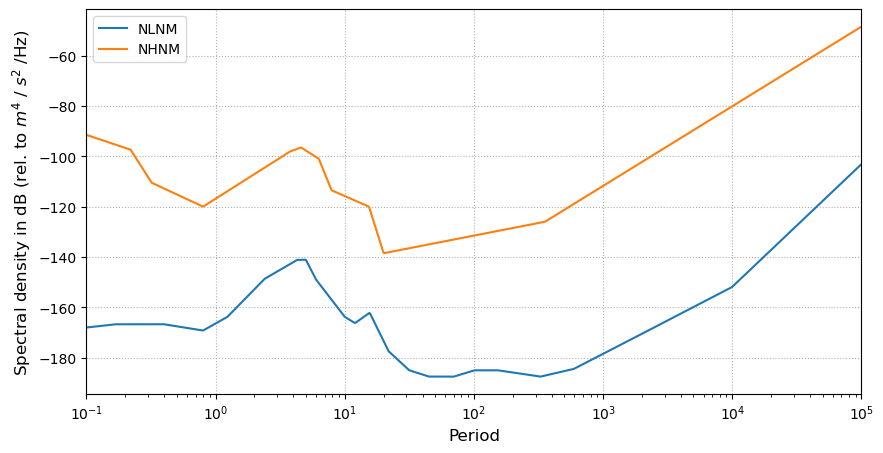

In [4]:
def __plot_noise_models(periods, nlnm, nhnm):
    plt.figure(figsize=(10,5))

    plt.semilogx(periods, nlnm, label="NLNM")
    plt.semilogx(periods, nhnm, label="NHNM")
    
    plt.xlabel('Period', fontsize=12)
    plt.ylabel(r'Spectral density in dB (rel. to $m^4$ / $s^2$ /Hz)', fontsize=12)
    
    plt.grid(ls=":")
    plt.legend()
    plt.xlim(periods[-1],periods[0])
    
    plt.show();
    
__plot_noise_models(nm_periods, nlnm, nhnm)

In [5]:
def __cutter(x, y, x_lower, x_upper):
    indices = []
    for i, k in enumerate(x):
        if k >= x_lower and k <= x_upper:
            indices.append(i)
    print(f" -> cutting from {x[indices[0]]} - {x[indices[-1]]}")
    return x[indices[0]:indices[-1]], y[indices[0]:indices[-1]] ,indices

In [6]:
nm_periods, nlnm, ind = __cutter(nm_periods,nlnm,1,200)

 -> cutting from 199.526 - 1.00462


### Read veloctiy profiles

In [7]:
# def __read_velocities_nc(path, fname):
    
#     print(f"\nreading {path}{fname}")
    
#     f = nc.Dataset(str(path)+str(fname),'r')
    
# #     for key in f.variables.keys():
# #            print(key)
            
# #     print(f.dimensions)          
# #     print(f.variables['period'][:])
# #     print(f.variables['latitude'][:])
# #     print(f.variables['longitude'][:])

#     vphase = f.variables['vel'][:]
#     # vphase.shape (57, 91, 181)
#     # 57 periods: 0.1 to 300 sec 
#     # on a grid for lon lat
        
#     period = f.variables['period']
    
#     return vphase, period

# vphase, period = __read_velocities_nc(config["workdir"], config["rayleigh_phase_nc"]);

In [8]:
if config['type'].lower() == "rayleigh":
    vphase = read_pickle(config['workdir']+"PHASE_VELOCITY_MODEL/Rayleigh_Average/"+"RAYLEIGH_vphase_land_only.pkl")
elif config['type'].lower() == "love":
    vphase = read_pickle(config['workdir']+"PHASE_VELOCITY_MODEL/Love_Average/"+"LOVE_vphase_land_only.pkl")
    
vphase.head()

,periods,periods_mod,vphase_max,vphase_median,vphase_mean,vphase_std,vphase_mad
0,0.1,0.15,3.190404,2.604705,2.518240,0.604101,0.498380
1,0.2,0.25,3.190404,2.596960,2.516723,0.597643,0.497550
2,0.3,0.35,3.190404,2.596805,2.515473,0.598883,0.494490
3,0.4,0.45,3.190404,2.607715,2.515017,0.602188,0.492240
4,0.5,0.55,3.190404,2.626535,2.533857,0.594105,0.476075


In [9]:
periods = vphase['periods']

## conversion from km/s to m/s
vphase_median = vphase['vphase_median']*1000
vphase_max = vphase['vphase_max']*1000
vphase_std = vphase['vphase_std']*1000
vphase_mad = vphase['vphase_mad']*1000

### Compute statistical measures

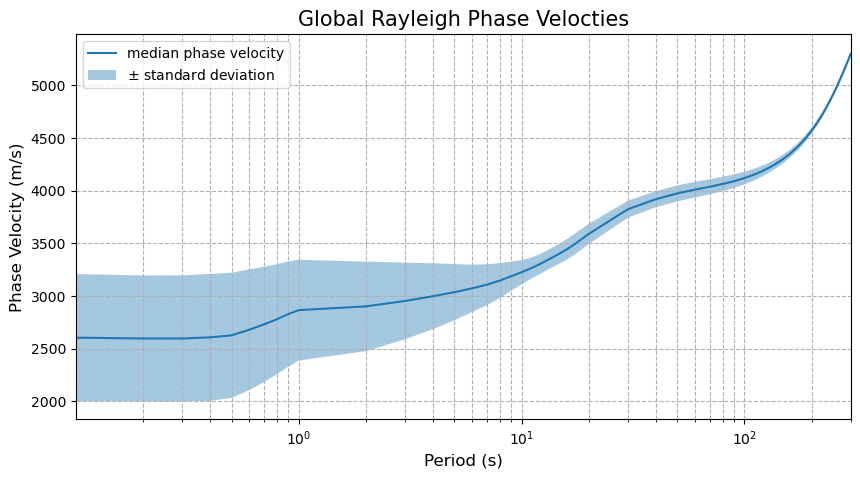

In [10]:
def __plot_veloctiy_model(vphase,config):

    period, med, std = vphase['periods'], vphase['vphase_median']*1000, vphase['vphase_std']*1000
    
    fig = plt.figure(figsize=(10,5))

    plt.plot(period, med, label="median phase velocity", zorder=2)
    plt.fill_between(period, y1=med-std, y2=med+std, alpha=0.4, label=r"$\pm$ standard deviation", zorder=1)

    plt.xscale("log")
    
    plt.xlabel("Period (s)", fontsize=12)
    plt.ylabel("Phase Velocity (m/s)", fontsize=12)
    plt.title(f"Global {config['type']} Phase Velocties", fontsize=15)    
    
    plt.legend()
    plt.grid(axis="both", which="both", ls="--", zorder=0)

    plt.xlim(min(period), max(period))
    
    plt.show();
    return fig

fig = __plot_veloctiy_model(vphase, config)

# fig.savefig(config['outdir_figures']+"Global_Rayleigh_Vphase"+".png", fmt="png", bbox_inches="tight", dpi=300, transparent=None)

In [11]:
vphase_median_interp = np.interp(nm_periods, periods, vphase_median)
# vphase_mean_interp = np.interp(nm_periods, period, vphase_mean)
vphase_max_interp = np.interp(nm_periods, periods, vphase_max)
vphase_std_interp = np.interp(nm_periods, periods, vphase_std)
vphase_mad_interp = np.interp(nm_periods, periods, vphase_mad)

## Compute Rotations and Conversions

In [12]:
def __conversion(data, informat=None, outformat=None):
    '''
    data:                  array 
    informat/outformat:    ASD, PSD, DB
    '''
    from numpy import log10, sqrt
    
    
    if informat == 'ASD' and outformat == 'PSD':
        return data**2
    
    elif informat == 'PSD' and outformat == 'ASD':
        return sqrt(data)

    elif informat == 'ASD' and outformat == 'DB':
        return 10*log10(data**2)
    
    elif informat == 'PSD' and outformat == 'DB':
        return 10*log10(data)
    
    elif informat == 'DB' and outformat == 'PSD':
        return 10**(data/10)
    
    elif informat == 'DB' and outformat == 'ASD':
        return sqrt(10**(data/10))
    
    else:
        print(" -> specified case not defined!")

In [13]:
snlnm = __conversion(nlnm, informat='DB', outformat='ASD')

rot_nlnm_med = np.array(snlnm / vphase_median_interp)
rot_nlnm_max = np.array(snlnm / vphase_max_interp)


## using standard deviation
rot_nlnm_upper = np.array(snlnm / (vphase_median_interp+vphase_std_interp))
rot_nlnm_lower = np.array(snlnm / (vphase_median_interp-vphase_std_interp))

## using median absolute deviation
# rot_nlnm_upper = np.array(snlnm / (vphase_median_interp+vphase_mad_interp))
# rot_nlnm_lower = np.array(snlnm / (vphase_median_interp-vphase_mad_interp))


rot_nlnm_max_psd       = __conversion(rot_nlnm_max, informat='ASD', outformat='PSD')
rot_nlnm_med_psd       = __conversion(rot_nlnm_med, informat='ASD', outformat='PSD')
rot_nlnm_upper_psd = __conversion(rot_nlnm_upper, informat='ASD', outformat='PSD')
rot_nlnm_lower_psd = __conversion(rot_nlnm_lower, informat='ASD', outformat='PSD')

rot_nlnm_max_db       = __conversion(rot_nlnm_max, informat='ASD', outformat='DB')
rot_nlnm_med_db       = __conversion(rot_nlnm_med, informat='ASD', outformat='DB')
rot_nlnm_upper_db = __conversion(rot_nlnm_upper_psd, informat='PSD', outformat='DB')
rot_nlnm_lower_db = __conversion(rot_nlnm_lower_psd, informat='PSD', outformat='DB')

## Write to File

In [14]:
df_out = DataFrame()

## write as PSD
df_out['period'] = nm_periods
df_out['rlnm_psd_median'] = rot_nlnm_med_psd
df_out['rlnm_psd_maximum'] = rot_nlnm_max_psd

df_out['rlnm_psd_upper'] = rot_nlnm_upper_psd
df_out['rlnm_psd_lower'] = rot_nlnm_lower_psd

fname = "rlnm_theory.csv"
df_out.to_csv(config['datadir_models']+fname, sep=",")
print(f" -> writing to {config['datadir_models']}{fname}")

 -> writing to /export/data/LNM/data/MODELS/rlnm_theory.csv


## Plots

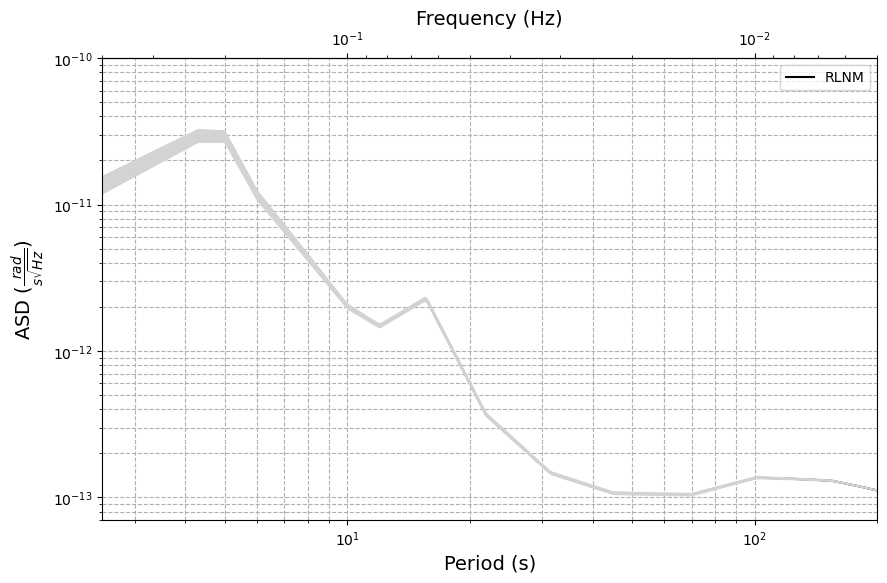

In [15]:
def __plot_rlnm():
    
    font = 14

    fig, ax = plt.subplots(1,1, figsize=(10,6))

    ax.plot(nm_periods, rot_nlnm_med, color="black", zorder=2, label="RLNM")
    
    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.fill_between(nm_periods, y1=rot_nlnm_upper, y2=rot_nlnm_lower, color="lightgrey", zorder=2)

    ax.set_xlim(2.5, 200)
    ax.set_ylim(7*10**-14, 10**-10)

    g = lambda x: 1/x
    ax2 = ax.secondary_xaxis("top", functions=(g,g))
    ax2.set_xlabel("Frequency (Hz)", fontsize=font)
    
    ax.grid(axis="both", which="both", ls="--", zorder=0)
    ax.legend()

    ax.set_xlabel("Period (s)", fontsize=font)
    ax.set_ylabel(r"ASD ($\frac{rad}{s \sqrt{Hz}}$)",fontsize=font)

    plt.show();
    return fig

fig = __plot_rlnm()

# fig.savefig(config['outdir_figures']+"RNLM_theory"+".png", fmt="png", bbox_inches="tight", dpi=300, transparent=None)

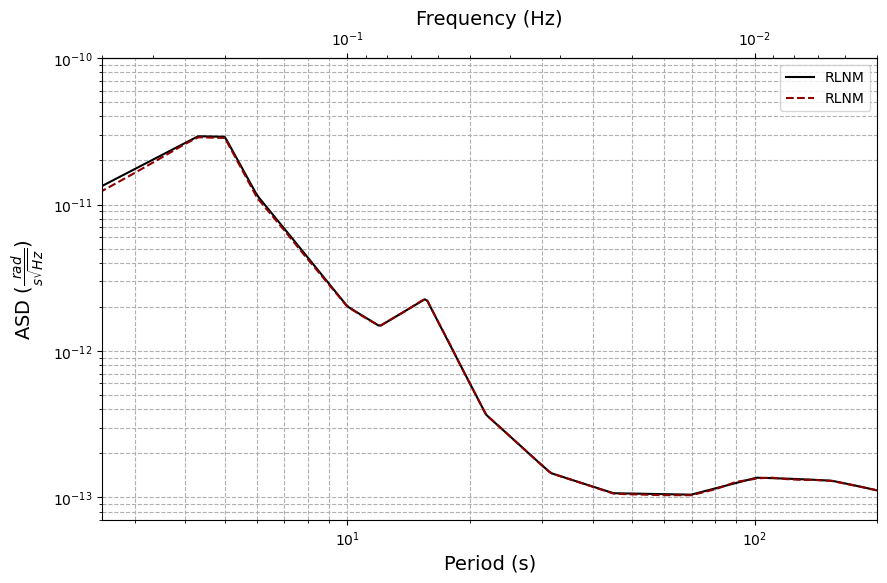

In [16]:
def __plot_rlnm():
    
    font = 14

    fig, ax = plt.subplots(1,1, figsize=(10,6))

    ax.plot(nm_periods, rot_nlnm_med, color="black", ls="-", zorder=2, label="RLNM")
    
    ax.plot(nm_periods, rot_nlnm_max, color="darkred", ls="--", zorder=2, label="RLNM")

#     ax3 = ax.twinx()
#     ax3.plot(nm_periods, snlnm)
#     ax3.set_yscale("log")

    ax.set_xscale("log")
    ax.set_yscale("log")

#     ax.fill_between(nm_periods, y1=rot_nlnm_upper, y2=rot_nlnm_lower, color="lightgrey", zorder=2)

    ax.set_xlim(2.5, 200)
    ax.set_ylim(7*10**-14, 10**-10)

    g = lambda x: 1/x
    ax2 = ax.secondary_xaxis("top", functions=(g,g))
    ax2.set_xlabel("Frequency (Hz)", fontsize=font)
    
    ax.grid(axis="both", which="both", ls="--", zorder=0)
    ax.legend()

    ax.set_xlabel("Period (s)", fontsize=font)
    ax.set_ylabel(r"ASD ($\frac{rad}{s \sqrt{Hz}}$)",fontsize=font)

    plt.show();
    return fig

fig = __plot_rlnm()

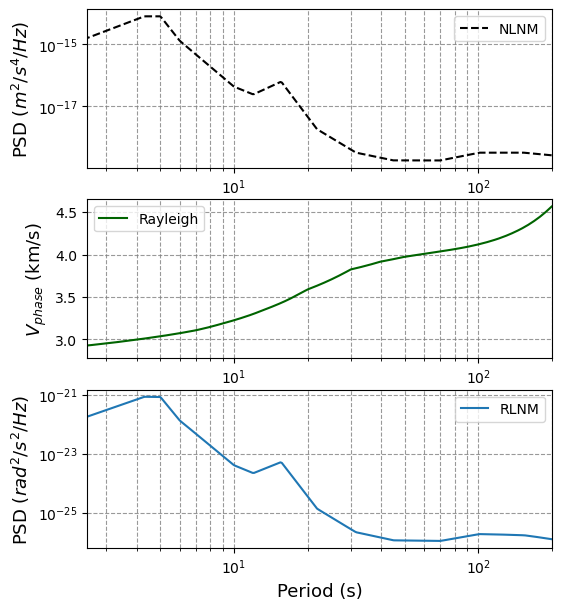

In [17]:
def __makeplot_explanation(pp, rot_nlnm_med, nlnm, vv_interp):

    
    font = 13

    fig, ax = plt.subplots(3,1,figsize=(6,7))

    ax[0].plot(pp, 10**(nlnm/10), color="k", ls="--", label="NLNM")
#     ax[0].plot(nm_periods, 10**(nlnm/10), color="k", ls="--")
    ax[0].set_ylabel(r"PSD $(m^2/s^4 /Hz)$", fontsize=font)
    ax[0].set_yscale("log")

    ax[1].plot(pp, vv_interp/1e3, color="darkgreen", label="Rayleigh")
    ax[1].set_ylabel(r"$V_{phase}$ (km/s)", fontsize=font)

    ax[2].plot(pp, rot_nlnm_med**2, label="RLNM")
    ax[2].set_ylabel(r"PSD $(rad^2/s^2 /Hz)$", fontsize=font)
    ax[2].set_yscale("log")
    ax[2].set_xlabel("Period (s)", fontsize=font)

    for i in range(3):
        ax[i].set_xlim(2.5, 200)
        ax[i].set_xscale("log")
        ax[i].grid(axis="both", which="both", color="grey", alpha=0.8, ls="--", zorder=0)
        ax[i].legend()

    fig.show();
    return fig 

fig = __makeplot_explanation(nm_periods, rot_nlnm_med, nlnm, vphase_median_interp)

# fig.savefig(config['outdir_figures']+"RLNM_theory_explanation"+".png", fmt="png", bbox_inches="tight", dpi=300, transparent=None)

## Make Probability PSD Plots

In [18]:
ipath = "/export/data/LNM/data/PHASE_VELOCITY_MODEL/Rayleigh_Average/RAYLEIGH_vphase_land_all.pkl"

import pickle 
with open(ipath,'rb') as f:
    vphase_land = pickle.load(f)

In [19]:
## convert nlnm from DB to ASD
snlnm = __conversion(nlnm, informat='DB', outformat='ASD')

## compute many rlnm models with velocities
models = []
for n in range(vphase_land.shape[0]):
    vv = np.interp(nm_periods, periods, vphase_land[n,:]) # velocity profiles in km/s
    models.append(snlnm / (vv * 1000)) # veloctiy 
models = np.array(models)


## convert it from ASD to DB
for k in range(models.shape[0]):
        models[k,:] =  __conversion(models[k,:], informat='ASD', outformat='DB')
models = np.array(models)

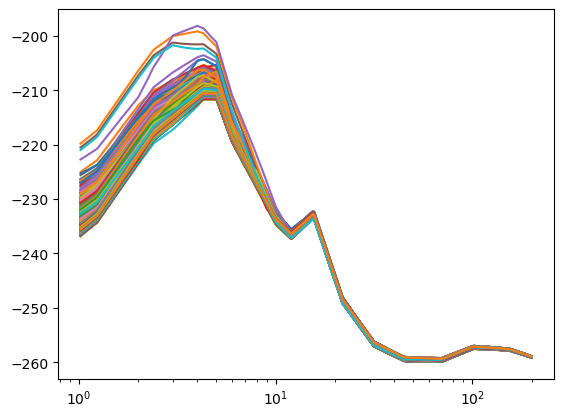

In [20]:
for k in range(models.shape[0]):
#     plt.plot(nm_periods, np.log10(models[k,:]))
    plt.plot(nm_periods, models[k,:])
    plt.xscale("log")
plt.show();

## It has to go in as DB to compute reasonable histograms!!!

In [21]:
def __calculate_density(psd_array, bins=20, density=False, axis=1):

    from numpy import argmax, std, median, isnan, array, histogram, nan, zeros, count_nonzero, log10, isinf, minimum
    from scipy.stats import median_abs_deviation as mad
    
    def __convert_to_log(in_psds):

        print(in_psds.shape)

        out_psds = np.zeros(in_psds.shape)
        rows_with_zeros = 0
        for i, psd in enumerate(in_psds):
            if np.count_nonzero(psd) != len(psd):
                rows_with_zeros +=1
                psd = [nan for val in psd if val == 0]
            out_psds[i,:] = np.log10(psd)
            if np.isinf(out_psds[i,:]).any():
                out_psds[i,:] = nan * ones(len(out_psds[i,:]))

        return out_psds

#     psd_array = __convert_to_log(psd_array)
    
    for m in range(psd_array.shape[0]):
        plt.plot(psd_array[m,:])
    
    ## exclude psds with only NaN values
    psds = array([psd for psd in psd_array if not isnan(psd).all()])

    
    ## find overall minimum and maxium values
    max_value = max([max(sublist) for sublist in psd_array if np.isfinite(sublist).all()])
    min_value = min([min(sublist) for sublist in psd_array if np.isfinite(sublist).all()])
    print(min_value, max_value)

    ## define empty lists
    dist, dist_maximas, bins_maximas, bins_medians, stds, mads, bins_minimum = [], [], [], [], [], [], []
    
    count = 0
    for h in range(len(psd_array[axis])):
        
        psd = psd_array[:,h]
        
        ## compute histograms
        hist, bin_edges = histogram(psd, bins=bins, range=(min_value, max_value), density=density);
                
        ## center bins
        bin_mids = 0.5*(bin_edges[1:] + bin_edges[:-1])
        
        ## normalization
#         if  True:
#             hist = [val / len(psd_array[:,h]) for val in hist]
#             config['set_density'] = True

        ## check if density works
        DX = abs(max_value-min_value)/bins
        SUM = sum(hist)
        if str(SUM*DX) != "1.0":
            count+=1
        
        ## modify histogram with range increment
        hist = hist*DX
        
        ## append values to list
        dist.append(hist)
        stds.append(std(hist))
        dist_maximas.append(max(hist))
        bins_maximas.append(bin_mids[argmax(hist)])
        mads.append(mad(hist)) 
        
        ## compute median
        psd = psd[~(isnan(psd))]
        bins_medians.append(median(psd[psd != 0]))
        bins_minimum.append(min(psd[psd != 0]))
        
    ## undo log conversion    
#     output = {}
#     output['dist'] = array(dist)
#     output['bin_mids'] = 10**array(bin_mids)
#     output['bins_maximas'] = 10**array(bins_maximas)
#     output['stds'] = 10**array(stds)
#     output['mads'] = 10**array(mads)
#     output['bins_medians'] = 10**array(bins_medians)
#     output['set_density'] = density
#     output['total'] = psd_array.shape[0]
    
    output = {}
    output['dist'] = array(dist)
    output['bin_mids'] = array(bin_mids)
    output['bins_maximas'] = array(bins_maximas)
    output['stds'] = array(stds)
    output['mads'] = array(mads)
    output['bins_medians'] = array(bins_medians)
    output['set_density'] = density
    output['total'] = psd_array.shape[0]
    output['bins_minimum'] = array(bins_minimum)
    
    if count > 0:
        print(f" {count} errors found for density computation!!!")
    
    return output

-259.951560089364 -198.17299950494711
 379 errors found for density computation!!!


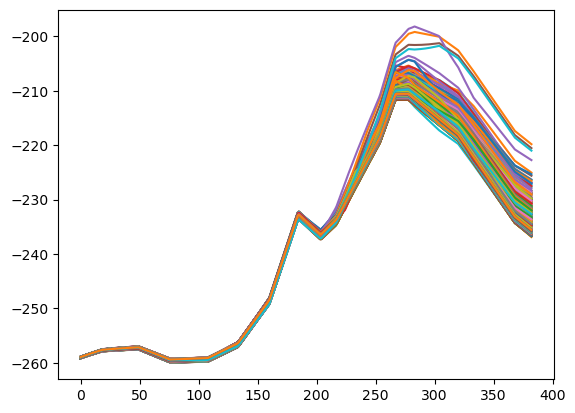

In [22]:
output = __calculate_density(models, bins=500, density=True)

In [23]:
def __makeplot_PPSD(ff, output, config, mode=None, plot_noise_models=False):

    from matplotlib import colors
    from numpy import ones, convolve, array, log10, roll, sqrt

    tmp = np.load(config['noise_models'])
    nm_periods, nlnm, nhnm = tmp['model_periods'], tmp['low_noise'], tmp['high_noise']; del tmp

    bins, bins_medians, bins_maximas, dist = output['bin_mids'], output['bins_medians'], output['bins_maximas'], output['dist']
    
    
    if mode == "PSD":
        y_axis = 10**(bins/10)
        medians = 10**(bins_medians/10)
        ymin, ymax = 1e-26, 1e-20
    elif mode == "ASD":
        y_axis = 10**(bins/20)
        medians = 10**(bins_medians/20)
        ymin, ymax = 1e-13, 1e-10
    elif mode == "DB":
        y_axis = bins
        medians = bins_medians
        ymin, ymax = -300, -180

    x_axis = ff

    ## plotting
    fig, ax = plt.subplots(1,1,figsize=(13,6))

    font=14

    cmap = plt.cm.get_cmap('magma_r')
#     cmap = plt.cm.get_cmap('gray_r')
    cmap.set_under(color='white')

    im = plt.pcolor(x_axis, y_axis, dist.T, 
                    cmap=cmap,
                    vmin=1e-12, 
                    alpha=0.99,
                   )

    ## add Frequency Axis
    g = lambda x: 1/x
    ax2 = ax.secondary_xaxis("top", functions=(g,g))
    ax2.set_xlabel("Frequency in Hz", fontsize=font, labelpad=5)
    ax2.set_xticklabels(1/ff, fontsize=11)    
    

    
    x_axis_mod = x_axis + (np.roll(x_axis,-1)-x_axis)/2; x_axis_mod[-1] = x_axis[-1] + (x_axis[-1]-x_axis[-2])/2

    ## medians
    plt.plot(x_axis_mod, medians, color='black', alpha=0.8, label="RNLM")
    plt.plot(x_axis_mod, 10**(output['bins_minimum']/10), color='black', alpha=0.8, label="RNLM")
    
    ## maximas
#     plt.plot(x_axis_mod, maximas, color='black', alpha=0.8, label="RNLM")


    if mode is not "DB":
        plt.yscale("log")
    

    ## modify x-axis
    plt.xscale('log')
    plt.xlim([min(x_axis), max(x_axis)])

#     plt.xlim(1, 300)
#     plt.fill_betweenx(range(ymin, ymax), x1=0, x2=2.5, color="grey", alpha=0.4)
#     plt.fill_betweenx(range(ymin, ymax), x1=200, x2=max(ff), color="grey", alpha=0.4)
        
    ## add colorbar
    caxes = fig.add_axes()
    cb = plt.colorbar(im, cax=caxes, alpha=1.0)
    
    if output['set_density']:
        cb.set_label("Propability Density", fontsize=font)
    else:
        cb.set_label("Counts", fontsize=font)
        cb.set_label("Propability Density", fontsize=font)
    
    if mode is "DB":
#         plt.ylabel(r"PPSD in dB (rel. to 1 m$^4$/s$^2$/$Hz$)", fontsize=font)
        plt.ylabel(r"PPSD in dB (rel. to 1 rad$^2$/s$^2$/$Hz$)", fontsize=font)
    elif mode is "PSD":
#         plt.ylabel(r"PPSD in m$^4$/s$^2$/$Hz$", fontsize=font)
        plt.ylabel(r"PPSD in $\frac{rad^2}{s^2 Hz}$", fontsize=font)
    elif mode is "ASD":
        plt.ylabel(r"PASD in $\frac{rad}{s \sqrt{Hz}}$", fontsize=font)
        
    plt.grid(axis="both", which="both", ls="--", zorder=0)
    plt.legend()
    
    plt.xlabel("Period in seconds", fontsize=font)

    plt.tick_params(axis='both', labelsize=font-2)

    plt.show();
    return fig

TypeError: add_axes() missing 1 required positional argument: 'rect'

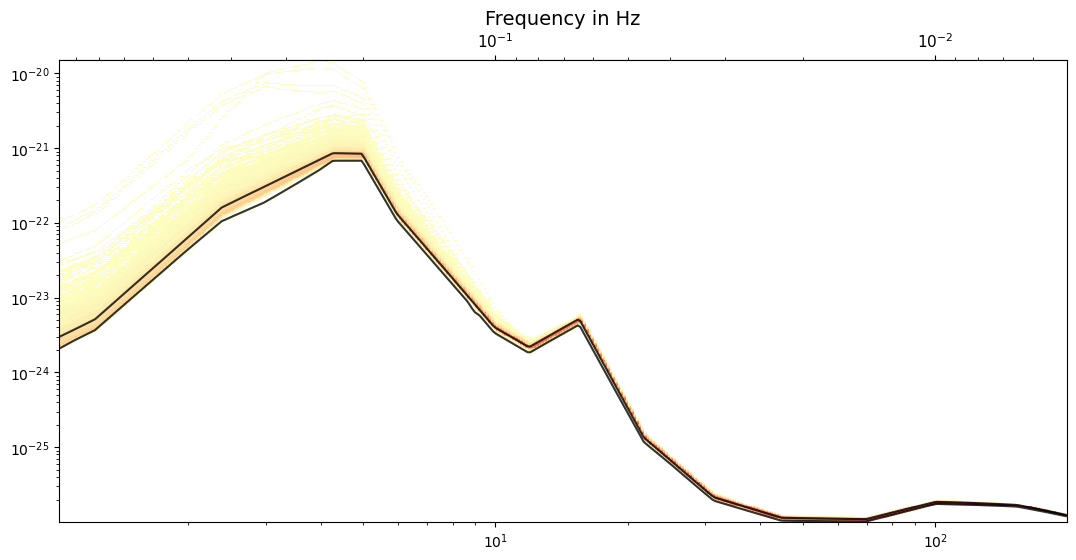

In [24]:
fig = __makeplot_PPSD(nm_periods, output, config, mode="PSD", plot_noise_models=False)

In [ ]:
# fig.savefig(config['outdir_figures']+"RLNM_theory_PPSD_DB"+".png", fmt="png", bbox_inches="tight", dpi=300, transparent=None)

## Write to File

In [ ]:
# import pickle

# output['period'] = nm_periods

# with open(config['datadir_models']+"RLNM_distribution.pkl",'wb') as f:
#     pickle.dump(output, f)

# Integrate RLNM

In [ ]:
rlnm = read_csv(config['workdir']+"MODELS/"+"rlnm_theory.csv")
rlnm

In [ ]:
f = 1/rlnm['period']

plt.loglog(1/rlnm['period'], rlnm['rlnm_psd_median'], color="k")
plt.loglog(1/rlnm['period'], rlnm['rlnm_psd_median']/(2*np.pi*f)**2, color="r")
plt.loglog(1/rlnm['period'], rlnm['rlnm_psd_median']/(f)**2, color="b")

In [ ]:
Pxx= rlnm['rlnm_psd_median']

N = len(Pxx)-1

new = np.zeros(N)
for n in range(N):
    new[n] = np.sqrt(abs(Pxx[n+1]-Pxx[n]) * abs(f[n+1]-f[n]))
    
plt.loglog(f[:-1], new)


In [ ]:
out_df = DataFrame()

out_df['frequency'] = f
out_df['period'] = rlnm['period']
out_df['rlnm_median (rad2/s2/Hz)'] = rlnm['rlnm_psd_median']
out_df['rlnm_median (rad2/Hz)'] = rlnm['rlnm_psd_median'] / (2*np.pi*f)**2

out_df.to_csv("~/Downloads/ModelForFelix_omega.csv")

In [ ]:
out_df = DataFrame()

out_df['frequency'] = f
out_df['period'] = rlnm['period']
out_df['rlnm_median (rad2/s2/Hz)'] = rlnm['rlnm_psd_median']
out_df['rlnm_median (rad2/Hz)'] = rlnm['rlnm_psd_median'] / (f)**2

out_df.to_csv("~/Downloads/ModelForFelix_freq.csv")